# Imports

In [1]:
import os
import numpy as np
import random
import cv2
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

from PIL import Image, ImageDraw, ImageFont

import pickle

from scipy.spatial.transform import Rotation as R
from sklearn.metrics.pairwise import cosine_similarity

import supervision as sv
import open3d as o3d
from cuml.cluster import DBSCAN
import cupy as cp

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [2]:
import torch
import torchvision.transforms as transforms
from torchvision.ops import box_convert
from torch import nn
import torch.nn.functional as F
from torchvision.transforms import Compose, Resize, CenterCrop, ToTensor, Normalize

# Setup

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [4]:
# imgs_dir = "/scratch/laksh.nanwani/instance_slam/JmbYfDe2QKZ/rgb"
# depth_dir = "/scratch/laksh.nanwani/instance_slam/JmbYfDe2QKZ/depth/"
# pose_dir = "/scratch/laksh.nanwani/instance_slam/JmbYfDe2QKZ/pose/"

imgs_dir = "/scratch/kumaradi.gupta/rtab_data/rgb"
depth_dir = "/scratch/kumaradi.gupta/rtab_data/depth/"
pose_dir = "/scratch/kumaradi.gupta/rtab_data/pose/"

img_dict_dir = "/home2/kumaradi.gupta/instance-map/rtab_img_dict.pkl"

In [5]:
# req_tags = ["table", "chair", "stool", "fan", "computer", 'stool', 
#             'pillar', 'couch', 'door', 'art', 'bed', 'bookshelf', 'picture', 'frame', 
#             'appliance', 'box', 'cabinet', 'wall','cubicle', 'pillar', 'equipment', 
#             'clock', 'board']

# colors = [
#     (255, 105, 97),  # Pastel Red
#     (255, 179, 71),  # Pastel Orange
#     (253, 253, 150), # Pastel Yellow
#     (119, 221, 119), # Pastel Green
#     (203, 153, 201), # Pastel Purple
#     (174, 198, 207), # Pastel Blue
#     (255, 209, 220), # Pastel Pink
#     (128, 128, 128), # Grey
#     (255, 0, 255),   # Magenta
#     (0, 0, 255),     # Blue
#     (0, 255, 255),   # Cyan
#     (255, 0, 0),     # Red
#     (139, 69, 19),   # Saddle Brown
#     (255, 140, 0),   # Dark Orange
#     (128, 0, 0),     # Maroon
#     (75, 0, 130),    # Indigo
#     (173, 216, 230), # Light Blue
#     (144, 238, 144), # Light Green
#     (255, 192, 203), # Pink
#     (210, 105, 30),  # Chocolate
#     (106, 90, 205),  # Slate Blue
#     (255, 165, 0),   # Orange
#     (70, 130, 180),  # Steel Blue
# ]

req_tags = ['chair', 'cupboard', 'stool', 'table', 'fan', 'door']
colors = [
    (255, 105, 97),  # Pastel Red
    (253, 253, 150), # Pastel Yellow
    (119, 221, 119), # Pastel Green
    (203, 153, 201), # Pastel Purple
    (174, 198, 207), # Pastel Blue
    (255, 209, 220), # Pastel Pink
]


def normalize_color(color_255):
    return tuple(val/255.0 for val in color_255)

In [6]:
# Load from pickle file
with open(img_dict_dir, 'rb') as file:
    img_dict = pickle.load(file)


In [7]:
img_dict['1']

{'img_path': '/scratch/kumaradi.gupta/rtab_data/rgb/1.png',
 'ram_tags': 'stool . chair . table . fan',
 'objs': {0: {'bbox': array([0.18052989, 0.09350195, 0.17888387, 0.15523534], dtype=float32),
   'phrase': 'fan',
   'prob': 0.7296888828277588,
   'mask': array([[False, False, False, ..., False, False, False],
          [False, False, False, ..., False, False, False],
          [False, False, False, ..., False, False, False],
          ...,
          [False, False, False, ..., False, False, False],
          [False, False, False, ..., False, False, False],
          [False, False, False, ..., False, False, False]]),
   'clip_embed': array([ 4.5090e-03,  1.1017e-01,  1.2744e-01, -3.5254e-01,  4.9194e-02,
           5.2155e-02,  4.9622e-02,  7.7100e-01, -4.7778e-01, -6.4148e-02,
           2.2363e-01, -1.0419e-01,  8.9307e-01,  1.0150e-01, -5.3564e-01,
           1.0315e-01, -1.8967e-02, -3.0298e-01, -2.1881e-02, -6.0913e-02,
          -2.8223e-01, -1.4709e-01, -8.4167e-02,  2.1936e-

# 3D AABB Calc

In [8]:
'''
img_dict = {img_name: {img_path: str,
                        ram_tags: list_of_str,
                        objs: {0: {bbox: [x1, y1, x2, y2],
                                    phrase: str,
                                    clip_embed: [1, 1024]},
                                    dino_embed: [1, 1024]},
                                    mask: [h, w],
                                    prob: float,
                                    aabb: arr}
                                1: {...},
                        }
            img_name: {...},
            }
'''

# go through the img_name and their data
# open the depth associated with an image from the depth folder (.npy file)

def get_depth(img_name):
    # depth_path = os.path.join(depth_dir, img_name + '.npy')
    # depth = np.load(depth_path)

    depth_path = os.path.join(depth_dir, img_name + '.png')
    depth = cv2.imread(depth_path, cv2.IMREAD_ANYDEPTH)
    depth = depth.astype(np.float32) / 1000.0
    return depth

def get_pose(img_name):
    pose_path = os.path.join(pose_dir, img_name + '.txt')

    # check if the pose file exists, if it doesn't, return None
    if not os.path.exists(pose_path):
        return None
    
    with open(pose_path, 'r') as f:
        pose = f.read().split()
        pose = np.array(pose).astype(np.float32)
    return pose

def get_sim_cam_mat_with_fov(h, w, fov):
    cam_mat = np.eye(3)
    cam_mat[0, 0] = cam_mat[1, 1] = w / (2.0 * np.tan(np.deg2rad(fov / 2)))
    cam_mat[0, 2] = w / 2.0
    cam_mat[1, 2] = h / 2.0
    return cam_mat

def get_realsense_cam_mat():
    K = np.array([[386.458, 0, 321.111],
              [0, 386.458, 241.595],
              [0, 0, 1]])
    return K

In [10]:
def create_point_cloud(depth, mask, cam_mat, pose, color=(1, 0, 0), camera_height=0.9):
    """
    Generates a point cloud from a depth image, camera intrinsics, mask, and pose.
    Only points within the mask and with valid depth are added to the cloud.
    Points are colored using the specified color.
    """

    # Reproject the depth to 3D space
    rows, cols = np.where(mask)

    depth_values = depth[rows, cols]
    valid_depth_indices = (depth_values > 0) & (depth_values <= 4)

    rows = rows[valid_depth_indices]
    cols = cols[valid_depth_indices]
    depth_values = depth_values[valid_depth_indices]

    points2d = np.vstack([cols, rows, np.ones_like(rows)])

    cam_mat_inv = np.linalg.inv(cam_mat)
    points3d_cam = cam_mat_inv @ points2d * depth_values

    # Parse the pose
    pos = np.array(pose[:3], dtype=float).reshape((3, 1))
    quat = pose[3:]
    rot = R.from_quat(quat).as_matrix()

    # # Apply rotation correction, to match the orientation z: backward, y: upward, and x: right
    # rot_ro_cam = np.eye(3)
    # rot_ro_cam[1, 1] = -1
    # rot_ro_cam[2, 2] = -1
    # rot = rot @ rot_ro_cam

    # # Apply position correction
    # pos[1] += camera_height

    # Create the pose matrix
    pose_matrix = np.eye(4)
    pose_matrix[:3, :3] = rot
    pose_matrix[:3, 3] = pos.reshape(-1)

    # Transform the points to global frame
    points3d_homo = np.vstack([points3d_cam, np.ones((1, points3d_cam.shape[1]))])
    points3d_global_homo = pose_matrix @ points3d_homo
    points3d_global = points3d_global_homo[:3, :]

    pcd = o3d.geometry.PointCloud()
    pcd.points = o3d.utility.Vector3dVector(points3d_global.T)

    # Assign color to the point cloud
    pcd.colors = o3d.utility.Vector3dVector(np.tile(color, (points3d_global.shape[1], 1)))

    return pcd


In [11]:
def get_obj_bounds(obj_pc):
    aabb = obj_pc.get_axis_aligned_bounding_box()
    min_bound = aabb.min_bound
    max_bound = aabb.max_bound
    obj_bounds = np.vstack((min_bound, max_bound))
    return obj_bounds

In [10]:
def filter_noise_dbscan(point_cloud, eps=0.1, min_points=15):
    # Apply DBSCAN clustering to the point cloud
    # with o3d.utility.VerbosityContextManager(o3d.utility.VerbosityLevel.Debug) as cm:
    #     labels = np.array(point_cloud.cluster_dbscan(eps=eps, min_points=min_points, print_progress=False))

    labels = np.array(point_cloud.cluster_dbscan(eps=eps, min_points=min_points, print_progress=False))

    # Find the largest cluster
    max_label = max(labels, key=list(labels).count)

    # Filter the point cloud to include only the largest cluster
    filtered_points = np.asarray(point_cloud.points)[labels == max_label]
    filtered_colors = np.asarray(point_cloud.colors)[labels == max_label]

    # Create a new point cloud with only the largest cluster
    filtered_pcd = o3d.geometry.PointCloud()
    filtered_pcd.points = o3d.utility.Vector3dVector(filtered_points)
    filtered_pcd.colors = o3d.utility.Vector3dVector(filtered_colors)

    return filtered_pcd


In [12]:
def fast_DBSCAN(point_cloud_o3d, eps=0.01, min_samples=20):
    # Convert Open3D point cloud to NumPy arrays
    points_np = np.asarray(point_cloud_o3d.points)
    colors_np = np.asarray(point_cloud_o3d.colors)

    # Convert NumPy array to CuPy array for GPU computations
    points_gpu = cp.asarray(points_np)

    # Create a DBSCAN instance with cuML
    dbscan_model = DBSCAN(eps=eps, min_samples=min_samples)

    # Fit the model to the GPU data
    dbscan_model.fit(points_gpu)

    # Get the labels for the clusters
    labels_gpu = dbscan_model.labels_

    # Convert the labels back to a NumPy array
    labels = cp.asnumpy(labels_gpu)

    # Filter the points and colors that are part of a cluster (label != -1)
    clustered_points = points_np[labels != -1]
    clustered_colors = colors_np[labels != -1]

    # Create a new Open3D point cloud with the clustered points and colors
    filtered_point_cloud_o3d = o3d.geometry.PointCloud()
    filtered_point_cloud_o3d.points = o3d.utility.Vector3dVector(clustered_points)
    filtered_point_cloud_o3d.colors = o3d.utility.Vector3dVector(clustered_colors)

    return filtered_point_cloud_o3d


In [13]:
for img_id, img_data in tqdm(img_dict.items()):

  if len(img_data['objs']) == 0:
    continue

  # img_path = img_data['img_path']
  # img = cv2.imread(img_path)

  depth = get_depth(img_id)

  pose = get_pose(img_id)
  if pose is None:
    continue
  
  # cam_mat = get_sim_cam_mat_with_fov(depth.shape[0], depth.shape[1], fov=90)
  cam_mat = get_realsense_cam_mat()

  for obj_id, obj_data in img_data['objs'].items():
    mask = obj_data['mask']

    pcd = create_point_cloud(depth, mask, cam_mat, pose)

    if len(pcd.points) <= 0:
      continue

    pcd = pcd.voxel_down_sample(voxel_size=0.01)
    pcd = fast_DBSCAN(pcd, eps=0.2, min_samples=200)
    obj_data['aabb'] = get_obj_bounds(pcd)

  0%|          | 0/2623 [00:00<?, ?it/s]

[W] [15:04:18.928998] Batch size limited by the chosen integer type (4 bytes). 41431 -> 32927. Using the larger integer type might result in better performance
[W] [15:04:28.784790] Batch size limited by the chosen integer type (4 bytes). 46492 -> 36950. Using the larger integer type might result in better performance
[W] [15:04:53.053365] Batch size limited by the chosen integer type (4 bytes). 33703 -> 26785. Using the larger integer type might result in better performance
[W] [15:04:58.258664] Batch size limited by the chosen integer type (4 bytes). 50687 -> 42367. Using the larger integer type might result in better performance
[W] [15:05:04.625706] Batch size limited by the chosen integer type (4 bytes). 39561 -> 31441. Using the larger integer type might result in better performance
[W] [15:05:07.818952] Batch size limited by the chosen integer type (4 bytes). 51228 -> 41920. Using the larger integer type might result in better performance
[W] [15:05:14.102213] Batch size limited

In [14]:
# Save updated img_dict with aabb

with open('/home2/kumaradi.gupta/instance-map/rtab_img_dict.pkl', 'wb') as file:
    pickle.dump(img_dict, file)

# Cluster Objects

In [15]:
def custom_cosine_similarity(vec1, vec2):
    # Ensure the vectors have the same shape
    if vec1.shape != vec2.shape:
        raise ValueError("Vectors must have the same shape.")

    # Compute the dot product of the vectors
    dot_product = np.dot(vec1, vec2)

    # Compute the magnitudes (Euclidean norms) of the vectors
    magnitude_vec1 = np.linalg.norm(vec1)
    magnitude_vec2 = np.linalg.norm(vec2)

    # Compute and return the cosine similarity
    similarity = dot_product / (magnitude_vec1 * magnitude_vec2)
    return similarity

def iou_3d(box1, box2):
    min_intersection = np.maximum(box1[0], box2[0])
    max_intersection = np.minimum(box1[1], box2[1])

    # Compute the intersection volume
    intersection_dims = np.maximum(max_intersection - min_intersection, 0)
    intersection_volume = np.prod(intersection_dims)

    # Compute the volumes of the individual bounding boxes
    volume_box1 = np.prod(box1[1] - box1[0])
    volume_box2 = np.prod(box2[1] - box2[0])

    # Compute the union volume
    union_volume = volume_box1 + volume_box2 - intersection_volume

    # Compute the IoU
    iou = intersection_volume / union_volume if union_volume != 0 else 0
    return iou

In [16]:
from scipy.cluster.hierarchy import linkage, fcluster
from scipy.spatial.distance import squareform
from collections import defaultdict

# Function to merge two clusters
def merge_data(cluster1, cluster2):
    # Compute the union of the bounding boxes
    obj_bounds1 = cluster1['aabb']
    obj_bounds2 = cluster2['aabb']

    min_bound = np.minimum(obj_bounds1[0], obj_bounds2[0])
    max_bound = np.maximum(obj_bounds1[1], obj_bounds2[1])

    # Merge source IDs: source_ids: [(img_id, obj_id), ...]
    source_ids = cluster1['source_ids'] + cluster2['source_ids']
    count = len(source_ids)

    # Average the embeddings
    avg_dino_embed = (np.array(cluster1['dino_embed']) * len(cluster1['source_ids']) +
                      np.array(cluster2['dino_embed']) * len(cluster2['source_ids'])) / count
    avg_clip_embed = (np.array(cluster1['clip_embed']) * len(cluster1['source_ids']) +
                      np.array(cluster2['clip_embed']) * len(cluster2['source_ids'])) / count
    return {
        'aabb': np.vstack((min_bound, max_bound)),
        'source_ids': source_ids,
        'dino_embed': avg_dino_embed,
        'clip_embed': avg_clip_embed
    }

In [42]:
#Old clustering algo: works but is wrong

def cluster_objects(img_dict, iou_threshold=0.5, dino_threshold=0.5):
    # A dictionary to store object-level data
    obj_dict = {}
    cluster_counter = 0

    # Cluster heirarchy 1
    # Iterate through the images and objects
    for img_id, img_data in tqdm(img_dict.items()):

        if len(img_data['objs']) == 0:
          continue

        for obj_id, obj_data in img_data['objs'].items():
          
            # Skip the object if aabb does not exist, in case of partial data only
            if 'aabb' not in obj_data:
                continue

            phrase = obj_data['phrase']
            phrase = phrase.split()[0]

            # Initialize the phrase entry if not present
            if phrase not in obj_dict:
                obj_dict[phrase] = {}

            # Iterate through existing clusters for this phrase
            found_cluster = False
            for cluster_id, cluster_data in list(obj_dict[phrase].items()):
                # Get the IoU for the current box and the cluster
                iou = iou_3d(obj_data['aabb'], cluster_data['aabb'])
                # dino_similarity = custom_cosine_similarity(obj_data['dino_embed'], cluster_data['dino_embed'])

                if (iou > iou_threshold):
                    # If IoU is above the threshold, update the cluster
                    found_cluster = True
                    obj_dict[phrase][cluster_id] = merge_data(cluster_data, {
                        'aabb': obj_data['aabb'],
                        'source_ids': [(img_id, obj_id)],
                        'dino_embed': obj_data['dino_embed'],
                        'clip_embed': obj_data['clip_embed']
                    })

                    # Check for possible merges with other clusters
                    for other_cluster_id, other_cluster_data in list(obj_dict[phrase].items()):
                        if other_cluster_id != cluster_id:
                            iou_merge = iou_3d(obj_dict[phrase][cluster_id]['aabb'],
                                               other_cluster_data['aabb'])

                            if iou_merge > iou_threshold:
                                merged_cluster = merge_data(obj_dict[phrase][cluster_id],
                                                            other_cluster_data)
                                obj_dict[phrase][cluster_id] = merged_cluster
                                del obj_dict[phrase][other_cluster_id]

                    break

            if not found_cluster:
                # If no cluster is found, add a new cluster
                cluster_id = len(obj_dict[phrase]) # Doesn't work because of arbitrary merging
                obj_dict[phrase][cluster_counter] = {
                    'aabb': obj_data['aabb'],
                    'source_ids': [(img_id, obj_id)],
                    'dino_embed': obj_data['dino_embed'],
                    'clip_embed': obj_data['clip_embed']
                }
                cluster_counter += 1

    return obj_dict


In [43]:
obj_dict = cluster_objects(img_dict, iou_threshold=0.35, dino_threshold=0.5)

  0%|          | 0/568 [00:00<?, ?it/s]

In [44]:
print(len(obj_dict['chair']), len(obj_dict['table']))

118 53


In [19]:
#New clustering algo: correct but the results are not great

def custom_distance(obj1, obj2):

    iou_weight = 0.7
    dino_weight = 0.3

    iou = iou_3d(obj1['aabb'], obj2['aabb'])

    dino_similarity = custom_cosine_similarity(obj1['dino_embed'], obj2['dino_embed'])

    distance = ((1 - iou) * iou_weight) + ((1 - dino_similarity) * dino_weight)
    # distance = (1 - iou)

    if distance < 0: # Happening in cases where iou and dino sim = 1
    #   print(f"Obj1: {obj1['source_ids']}, Obj2: {obj2['source_ids']}")
      distance = 0

    return distance

def fcluster_objects(img_dict, dist_threshold=0.7):
    # Group objects by phrase
    phrase_objects = defaultdict(list)
    for img_id, img_data in img_dict.items():
        for obj_id, obj_data in img_data['objs'].items():

            if 'aabb' not in obj_data:
                continue

            obj_data_with_source = obj_data.copy()
            obj_data_with_source['source_ids'] = [(img_id, obj_id)]  # Add source information

            phrase = obj_data_with_source['phrase'].split()[0]
            phrase_objects[phrase].append(obj_data_with_source)

    # Dictionary to store the final merged clusters
    merged_clusters = {}

    # Perform clustering for each phrase
    for phrase, objects_list in tqdm(phrase_objects.items()):

        # Compute pairwise distances and convert to condensed form
        n = len(objects_list)
        distances = np.zeros((n, n))
        for i in range(n):
            for j in range(i + 1, n):  # Only calculate upper triangular part
                distances[i, j] = custom_distance(objects_list[i], objects_list[j])
                distances[j, i] = distances[i, j]  # Symmetric matrix
        distances = squareform(distances)

        # Perform hierarchical clustering
        Z = linkage(distances, method='single')

        # Cut the dendrogram to form final clusters
        cluster_labels = fcluster(Z, t=dist_threshold, criterion='distance')

        # Merge clusters for this phrase
        phrase_clusters = {}
        for idx, label in enumerate(cluster_labels):
            if label not in phrase_clusters:
                phrase_clusters[label] = objects_list[idx]
            else:
                # Merge data using your existing merge_data function
                phrase_clusters[label] = merge_data(phrase_clusters[label], objects_list[idx])

        # Store the merged clusters for this phrase
        merged_clusters[phrase] = phrase_clusters

    return merged_clusters


In [20]:
obj_dict = fcluster_objects(img_dict, dist_threshold=0.45)

  0%|          | 0/5 [00:00<?, ?it/s]

In [21]:
print(len(obj_dict['chair']), len(obj_dict['table']))

480 242


In [22]:
n = 10  # Threshold for minimum number of source_ids

# Iterate through phrases (classes) in the obj_dict
for phrase, obj_list in list(obj_dict.items()):
    # Iterate through the cluster_ids in the content
    for cluster_id, cluster_data in list(obj_list.items()):
        # Check the length of the source_ids for this cluster
        if len(cluster_data['source_ids']) <= n:
            # Delete this cluster if the number of source_ids is less than or equal to n
            del obj_dict[phrase][cluster_id]
    
    # Delete the phrase itself if it contains no clusters
    if not obj_dict[phrase]:
        del obj_dict[phrase]


In [23]:
print(len(obj_dict['chair']), len(obj_dict['table']))

39 15


In [35]:
def create_obj_point_clouds(obj_dict, img_dict, output_dir, voxel_size=0.01, color=(1, 0, 0)):
    # Ensure the outputs directory exists
    if not os.path.exists(output_dir):
        os.mkdir(output_dir)

    # Iterate through the phrases and clusters
    for phrase, clusters in tqdm(obj_dict.items()):
        # Create a directory for this phrase if it doesn't exist
        phrase_dir = os.path.join(output_dir, phrase)
        if not os.path.exists(phrase_dir):
            os.mkdir(phrase_dir)

        color = colors[req_tags.index(phrase)]
        color = normalize_color(color)

        # Iterate through the clusters
        for cluster_id, cluster_data in tqdm(clusters.items()):
            # Initialize an empty point cloud to accumulate points from all source IDs
            final_pcd = o3d.geometry.PointCloud()

            # Iterate through the source IDs for this cluster
            for img_id, obj_id in cluster_data['source_ids']:
                # Get the required information
                depth = get_depth(img_id)
                pose = get_pose(img_id)

                if pose is None:
                    continue

                # cam_mat = get_sim_cam_mat_with_fov(depth.shape[0], depth.shape[1], fov=90)
                cam_mat = get_realsense_cam_mat()

                mask = img_dict[img_id]['objs'][obj_id]['mask']

                # Create the point cloud for this source ID
                pcd = create_point_cloud(depth, mask, cam_mat, pose, color=color)
                pcd = pcd.voxel_down_sample(voxel_size=voxel_size)
                pcd = fast_DBSCAN(pcd, eps=0.2, min_samples=200)

                # Perform ICP registration if final_pcd is not empty
                if not final_pcd.is_empty():
                    # Set ICP configuration
                    config = o3d.pipelines.registration.ICPConvergenceCriteria(relative_fitness=1e-6,
                                                                            relative_rmse=1e-6, max_iteration=1000)
                    # Run ICP
                    reg_p2p = o3d.pipelines.registration.registration_icp(
                        pcd, final_pcd, 0.02, np.eye(4),
                        o3d.pipelines.registration.TransformationEstimationPointToPoint(),
                        config)
                    
                    # Update pcd based on the transformation matrix obtained from ICP
                    pcd.transform(reg_p2p.transformation)


                # Combine with the final point cloud
                final_pcd += pcd

            # Downsample and filter the final point cloud
            final_pcd = final_pcd.voxel_down_sample(voxel_size=voxel_size)
            final_pcd = fast_DBSCAN(final_pcd, eps=0.2, min_samples=15)

            # Save the final point cloud for this cluster
            file_path = os.path.join(phrase_dir, f'{cluster_id}.ply')
            o3d.io.write_point_cloud(file_path, final_pcd)


In [36]:
create_obj_point_clouds(obj_dict, img_dict, voxel_size=0.01, output_dir='/home2/kumaradi.gupta/instance-map/output')

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/39 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

# Experiments

In [ ]:
# Compare the embeddings of all images, first object instance

embedding_type = 'dino_embed'
# Sort the img_ids
sorted_img_ids = sorted(img_dict.keys(), key=lambda x: [int(i) for i in x.split('_')])

# Extract the embeddings in the sorted order
embeddings = [img_dict[img_id]['objs'][0][embedding_type] for img_id in sorted_img_ids]

# Calculate the cosine similarity matrix
similarity_matrix = cosine_similarity(embeddings)

# Visualize the similarity matrix as a heatmap
plt.figure(figsize=(8, 8))
plt.imshow(similarity_matrix, cmap='hot', interpolation='nearest')
plt.colorbar(label='Cosine Similarity')
plt.title('Clip Embedding Similarity')

# Add the similarity scores as text labels
for i in range(len(similarity_matrix)):
    for j in range(len(similarity_matrix)):
        plt.text(j, i, f'{similarity_matrix[i, j]:.2f}', ha='center', va='center', color='white' if similarity_matrix[i, j] < 0.5 else 'black')

plt.xticks(range(len(img_dict)), sorted_img_ids, rotation=90)
plt.yticks(range(len(img_dict)), sorted_img_ids)
plt.show()



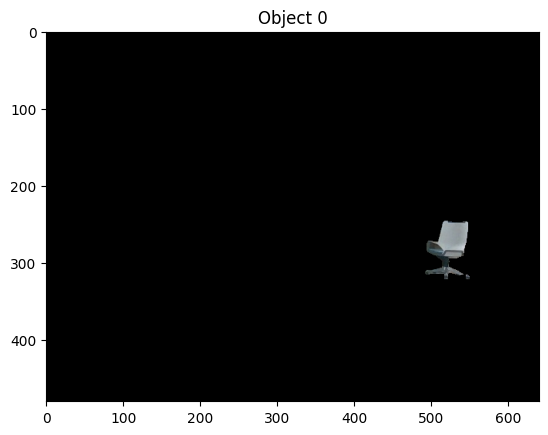

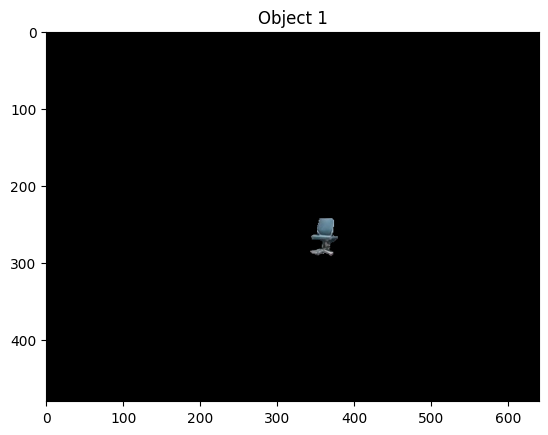

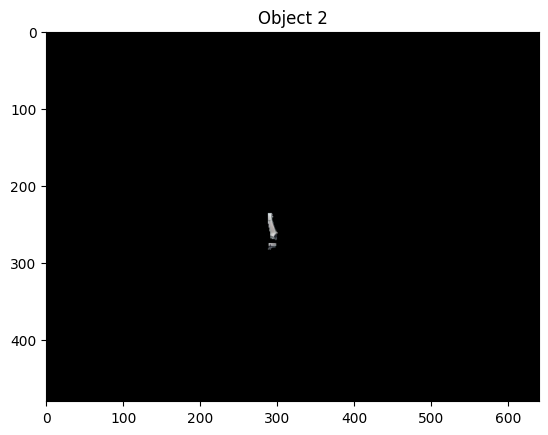

In [40]:
#Code to visualize separate masks for a single image

img_id = '1510'

# Load the image
img_path = img_dict[img_id]['img_path']
img = cv2.imread(img_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert from BGR to RGB

# Get the object data for the image
objs = img_dict[img_id]['objs']

# Loop through each object in the image
for obj_index, obj_data in objs.items():
    # Get the mask for the object
    mask = obj_data['mask']

    # If the mask isn't a numpy array, convert it to one
    if not isinstance(mask, np.ndarray):
        mask = mask.numpy()

    # Apply the mask to the image. This assumes your mask is binary (0s and 1s).
    # If it isn't, you may need to adjust this step accordingly.
    masked_image = img * np.expand_dims(mask, axis=2)

    # Display the masked image
    plt.figure()
    plt.imshow(masked_image)
    plt.title(f"Object {obj_index}")
    plt.show()


In [ ]:
#Code to draw the segmentation mask on the image
from torchvision.utils import draw_segmentation_masks

img_id = 'JmbYfDe2QKZ_123'

# Load the image
img_path = img_dict[img_id]['img_path']
img = Image.open(img_path)  # Load with PIL to avoid needing to convert color spaces

transform = transforms.Compose([transforms.ToTensor()])
img_tensor = transform(img)
img_tensor = (img_tensor * 255).byte()


masks = []
mask_colors = []

objs = img_dict[img_id]['objs']

for obj_index, obj_data in objs.items():
    mask = obj_data['mask']

    phrase = obj_data['phrase']
    phrase = phrase.split()[0] #Use only the first phrase

    # If the mask isn't a numpy array, convert it to one
    if not isinstance(mask, np.ndarray):
        mask = mask.numpy()

    # Add the mask to the list of masks
    masks.append(mask)
    #Cheeck the color for the mask and add it to the list
    color = colors[req_tags.index(phrase)]
    mask_colors.append(color)

# Convert the masks to a boolean tensor
masks_tensor = torch.tensor(masks, dtype=torch.bool)

# Draw all masks on the image
result = draw_segmentation_masks(img_tensor, masks_tensor, colors=mask_colors)

# Convert the result tensor back to a PIL image, transpose the dimensions back to H,W,C for PIL
result_img = Image.fromarray(result.permute(1, 2, 0).byte().cpu().numpy())

# Display the image with all masks
plt.imshow(result_img)
plt.show()


In [14]:
# Code to check if there are multiple phrases for a single object

for img_id, img_data in tqdm(img_dict.items()):
    objs_data = img_data['objs']
    for obj_id, obj_data in objs_data.items():
        phrase = obj_data['phrase']
        words = phrase.split()  # Splits the phrase into words using whitespace as the separator
        if len(words) > 1:  # Checks if there are more than one word
            print(f'{img_id}_{obj_id}: {phrase}')


  0%|          | 0/568 [00:00<?, ?it/s]

JmbYfDe2QKZ_445_3: stool chair
JmbYfDe2QKZ_126_1: stool table
JmbYfDe2QKZ_245_3: stool table
JmbYfDe2QKZ_563_2: couch chair
JmbYfDe2QKZ_443_3: stool chair
JmbYfDe2QKZ_209_3: stool table
JmbYfDe2QKZ_294_0: closet door
JmbYfDe2QKZ_448_3: stool chair
JmbYfDe2QKZ_33_3: couch chair
JmbYfDe2QKZ_293_0: closet door
JmbYfDe2QKZ_293_1: closet door
JmbYfDe2QKZ_125_2: stool table
JmbYfDe2QKZ_441_4: stool chair
JmbYfDe2QKZ_533_5: stool table
JmbYfDe2QKZ_332_0: closet door
JmbYfDe2QKZ_44_4: couch chair
JmbYfDe2QKZ_471_3: stool chair
JmbYfDe2QKZ_35_8: stool table
JmbYfDe2QKZ_465_5: stool chair
JmbYfDe2QKZ_210_2: stool table


In [ ]:
# Code to print the similarity of dino embeds for all objects of an image

img_id = 'JmbYfDe2QKZ_123'
objs_data = img_dict[img_id]['objs']

dino_embeds = [obj_data['dino_embed'] for obj_id, obj_data in objs_data.items()]
phrases = [obj_data['phrase'] for obj_id, obj_data in objs_data.items()]

# Reshaping the embeds to fit the input shape for cosine_similarity
dino_embeds_matrix = np.array(dino_embeds).reshape(-1, 768)

# Calculating the cosine similarity
similarity_matrix = cosine_similarity(dino_embeds_matrix)

# print("Cosine Similarities:")
# print(similarities)

# Visualize the similarity matrix as a heatmap
plt.figure(figsize=(8, 8))
plt.imshow(similarity_matrix, cmap='hot', interpolation='nearest')
plt.colorbar(label='Cosine Similarity')
plt.title('Dino Embedding Similarity')

# Add the similarity scores as text labels
for i in range(len(similarity_matrix)):
    for j in range(len(similarity_matrix)):
        plt.text(j, i, f'{similarity_matrix[i, j]:.2f}', ha='center', va='center', color='white' if similarity_matrix[i, j] < 0.5 else 'black')

plt.xticks(range(len(phrases)), phrases, rotation=90)
plt.yticks(range(len(phrases)), phrases)
plt.show()


In [ ]:
# Visualize 3D bounding boxes without DBSCAN
from mpl_toolkits.mplot3d.art3d import Poly3DCollection

img_ids = ['JmbYfDe2QKZ_123']

# Normalize the colors to (0-1) range
colors_normalized = [(r/255, g/255, b/255) for r, g, b in colors]

# Create a mapping of phrases to colors
color_mapping = {phrase: color for phrase, color in zip(req_tags, colors_normalized)}
default_color = 'gray' # Default color if the phrase is not in the mapping

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Finding the global min and max bounds across all bounding boxes
global_min_bound = np.array([float('inf')] * 3)
global_max_bound = np.array([float('-inf')] * 3)

for img_id in img_ids:
  obj_data = img_dict[img_id]['objs']

  for obj_id, data in tqdm(obj_data.items()):

      bounds = data['aabb']

      phrase = data['phrase']
      phrase = phrase.split()[0]

      # if phrase != 'chair':
      #     continue

      color = color_mapping.get(phrase, default_color)

      min_bound, max_bound = bounds
      min_bound = [min_bound[0], min_bound[2], min_bound[1]]
      max_bound = [max_bound[0], max_bound[2], max_bound[1]]

      global_min_bound = np.minimum(global_min_bound, min_bound)
      global_max_bound = np.maximum(global_max_bound, max_bound)

      # Define vertices of the bounding box
      vertices = [
          [min_bound[0], min_bound[1], min_bound[2]],
          [max_bound[0], min_bound[1], min_bound[2]],
          [max_bound[0], max_bound[1], min_bound[2]],
          [min_bound[0], max_bound[1], min_bound[2]],
          [min_bound[0], min_bound[1], max_bound[2]],
          [max_bound[0], min_bound[1], max_bound[2]],
          [max_bound[0], max_bound[1], max_bound[2]],
          [min_bound[0], max_bound[1], max_bound[2]]
      ]

      # Define faces using vertices
      faces = [
          [vertices[0], vertices[1], vertices[2], vertices[3]],
          [vertices[4], vertices[5], vertices[6], vertices[7]],
          [vertices[0], vertices[1], vertices[5], vertices[4]],
          [vertices[2], vertices[3], vertices[7], vertices[6]],
          [vertices[1], vertices[2], vertices[6], vertices[5]],
          [vertices[4], vertices[7], vertices[3], vertices[0]]
      ]

      # Plot the faces
      for face in faces:
          poly3d = [[vertice[0], vertice[1], vertice[2]] for vertice in face]
          ax.add_collection3d(Poly3DCollection([poly3d], facecolors=color, linewidths=1, edgecolors='k', alpha=0.25))


# Setting the axes limits based on the global bounds
ax.set_xlim([global_min_bound[0], global_max_bound[0]])
ax.set_ylim([global_min_bound[1], global_max_bound[1]])
ax.set_zlim([global_min_bound[2], global_max_bound[2]])
plt.show()


  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/8 [00:00<?, ?it/s]

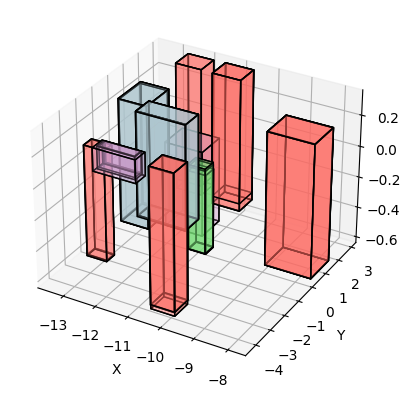

In [76]:
# Visualize 3D bounding boxes with DBSCAN
from mpl_toolkits.mplot3d.art3d import Poly3DCollection

img_ids = ['JmbYfDe2QKZ_1', 'JmbYfDe2QKZ_2', 'JmbYfDe2QKZ_3']

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Normalize the colors to (0-1) range
colors_normalized = [(r/255, g/255, b/255) for r, g, b in colors]

# Create a mapping of phrases to colors
color_mapping = {phrase: color for phrase, color in zip(req_tags, colors_normalized)}
default_color = 'gray' # Default color if the phrase is not in the mapping

# Finding the global min and max bounds across all bounding boxes
global_min_bound = np.array([float('inf')] * 3)
global_max_bound = np.array([float('-inf')] * 3)

final_pcd = o3d.geometry.PointCloud()

for img_id in img_ids:
  obj_data = img_dict[img_id]['objs']
  depth = get_depth(img_id)
  pose = get_pose(img_id)

#   cam_mat = get_sim_cam_mat_with_fov(depth.shape[0], depth.shape[1], fov=90)
  cam_mat = get_realsense_cam_mat()
  
  for obj_id, data in tqdm(obj_data.items()):

      #Reconstruct pointcloud
      mask = data['mask']
      phrase = data['phrase']
      phrase = phrase.split()[0]

      color = color_mapping.get(phrase, default_color)

      pcd = create_point_cloud(depth, mask, cam_mat, pose)
      pcd = pcd.voxel_down_sample(voxel_size=0.01)
      pcd = fast_DBSCAN(pcd, eps=0.2, min_samples=200)

      final_pcd += pcd

      bounds = get_obj_bounds(pcd)
      # bounds = data['aabb']
      min_bound, max_bound = bounds

      min_bound = [min_bound[0], min_bound[2], min_bound[1]]
      max_bound = [max_bound[0], max_bound[2], max_bound[1]]

      global_min_bound = np.minimum(global_min_bound, min_bound)
      global_max_bound = np.maximum(global_max_bound, max_bound)

      # Define vertices of the bounding box
      vertices = [
          [min_bound[0], min_bound[1], min_bound[2]],
          [max_bound[0], min_bound[1], min_bound[2]],
          [max_bound[0], max_bound[1], min_bound[2]],
          [min_bound[0], max_bound[1], min_bound[2]],
          [min_bound[0], min_bound[1], max_bound[2]],
          [max_bound[0], min_bound[1], max_bound[2]],
          [max_bound[0], max_bound[1], max_bound[2]],
          [min_bound[0], max_bound[1], max_bound[2]]
      ]

      # Define faces using vertices
      faces = [
          [vertices[0], vertices[1], vertices[2], vertices[3]],
          [vertices[4], vertices[5], vertices[6], vertices[7]],
          [vertices[0], vertices[1], vertices[5], vertices[4]],
          [vertices[2], vertices[3], vertices[7], vertices[6]],
          [vertices[1], vertices[2], vertices[6], vertices[5]],
          [vertices[4], vertices[7], vertices[3], vertices[0]]
      ]

      # Plot the faces
      for face in faces:
          poly3d = [[vertice[0], vertice[1], vertice[2]] for vertice in face]
          ax.add_collection3d(Poly3DCollection([poly3d], facecolors=color, linewidths=1, edgecolors='k', alpha=0.25))

# Save the pointcloud
o3d.io.write_point_cloud('/home2/kumaradi.gupta/instance-map/sample_pcd/test4.ply', final_pcd)

# Setting the axes limits based on the global bounds
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

ax.set_xlim([global_min_bound[0], global_max_bound[0]])
ax.set_ylim([global_min_bound[1], global_max_bound[1]])
ax.set_zlim([global_min_bound[2], global_max_bound[2]])
plt.show()


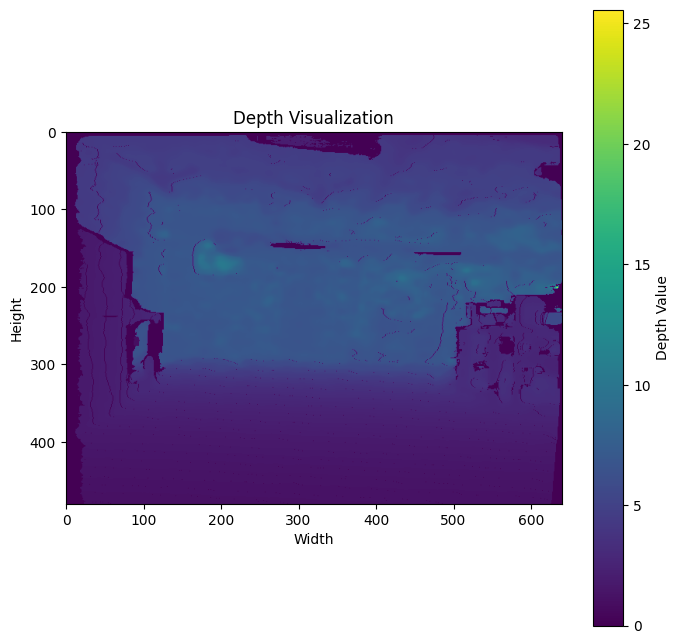

In [29]:
img_id = '1'
depth_data = get_depth(img_id)

# only keep the depth values that are within the valid range
depth_data[depth_data < 0] = 0
depth_data[depth_data > 3] = 0

# Visualize the depth data as a heatmap
plt.figure(figsize=(8, 8))
plt.imshow(depth_data, cmap='viridis')  # You can choose different colormaps like 'gray', 'plasma', etc.
plt.colorbar(label='Depth Value')
plt.title('Depth Visualization')
plt.xlabel('Width')
plt.ylabel('Height')
plt.show()
